<a href="https://colab.research.google.com/github/Arpitkamal/Deep-Learning---Deep-Convolutional-Neural-Networks/blob/master/LargeCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline

*   Loading datasets - Transforming images
*   VGG-16 with modification to network head
*   using pre-trained models
*   Storing intermediate models
*   Resnet
*   Inception v3
*   Exercise





In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim #for backpropagation

In [4]:
device = torch.device("cuda:0")
print(device)

cuda:0


# Dataset, transforms and visualisation

In [5]:
transform_train = transforms.Compose([
         transforms.RandomResizedCrop(224),  #resizing and croping
         transforms.ToTensor(),              #converted to tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   #Normalization                         
])

transform_test = transforms.Compose([
         transforms.RandomResizedCrop(224),  #resizing and croping
         transforms.ToTensor(),              #converted to tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   #Normalization                         
])



In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform= transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
num_classes = 10

In [8]:
batch_size = 4

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [10]:
dataiter = iter(trainloader) #instantiating iterator for trainloader 
images, labels = dataiter.next() # return one batch

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
8


In [11]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5                #converting the image to numpy and unnormalizing it 
  plt.figure(figsize=(batch_size, 1))          #(width, height)
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [12]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

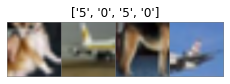

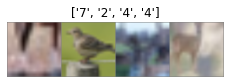

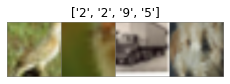

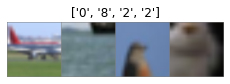

In [13]:
for i in range(4):
  show_batch_images(trainloader)

# Creating VGG-16

In [14]:
from torchvision import models

In [15]:
vgg = models.vgg16_bn()

In [16]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [17]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [19]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


We have to change output features to 10

In [21]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]  #excluding last linear layer
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) # num_classes is defined to be 10 earlier
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [22]:
vgg.classifier = nn.Sequential(*mod_classifier) #defining modified classifier
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Training the VGG 